In [1]:
from dotenv import load_dotenv
load_dotenv()

import uuid
from typing import List
from pydantic import BaseModel, Field

from langchain_perplexity import ChatPerplexity
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

In [2]:
store = InMemoryStore()

In [3]:
SYSTEM_PROMPT_TEMPLATE = """You are a helpful assistant with memory capabilities.
If user-specific memory is available, use it to personalize 
your responses based on what you know about the user.

Your goal is to provide relevant, friendly, and tailored 
assistance that reflects the user’s preferences, context, and past interactions.

If the user’s name or relevant personal context is available, always personalize your responses by:
    – Always Address the user by name (e.g., "Sure, Nitish...") when appropriate
    – Referencing known projects, tools, or preferences (e.g., "your MCP server python based project")
    – Adjusting the tone to feel friendly, natural, and directly aimed at the user

Avoid generic phrasing when personalization is possible.

Use personalization especially in:
    – Greetings and transitions
    – Help or guidance tailored to tools and frameworks the user uses
    – Follow-up messages that continue from past context

Always ensure that personalization is based only on known user details and not assumed.

In the end suggest 3 relevant further questions based on the current response and user profile

The user’s memory (which may be empty) is provided as: {user_details_content}
"""

In [4]:
memory_llm = ChatPerplexity(model="sonar-pro", temperature=0)

In [5]:
class MemoryItem(BaseModel):
    text: str = Field(description="Atomic user memory")
    is_new: bool = Field(description="True if new, false if duplicate")

In [6]:
class MemoryDecision(BaseModel):
    should_write: bool
    memories: List[MemoryItem] = Field(default_factory=list)

In [7]:
memory_extractor = memory_llm.with_structured_output(MemoryDecision)

In [8]:
MEMORY_PROMPT = """You are responsible for updating and maintaining accurate user memory.

CURRENT USER DETAILS (existing memories):
{user_details_content}

TASK:
- Review the user's latest message.
- Extract user-specific info worth storing long-term (identity, stable preferences, ongoing projects/goals).
- For each extracted item, set is_new=true ONLY if it adds NEW information compared to CURRENT USER DETAILS.
- If it is basically the same meaning as something already present, set is_new=false.
- Keep each memory as a short atomic sentence.
- No speculation; only facts stated by the user.
- If there is nothing memory-worthy, return should_write=false and an empty list.
"""

In [10]:
def remember_node(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("user", user_id, "details")

    # existing memory
    items = store.search(namespace)
    existing = "\n".join(it.value["data"] for it in items) if items else "(empty)"

    # last user message
    last_msg = state["messages"][-1].content

    decision: MemoryDecision = memory_extractor.invoke(
        [
            SystemMessage(content=MEMORY_PROMPT.format(user_details_content=existing)),
            {"role": "user", "content": last_msg},
        ]
    )

    if decision.should_write:
        for mem in decision.memories:
            if mem.is_new:
                store.put(namespace, str(uuid.uuid4()), {"data": mem.text})

    return {} 

In [11]:
chat_llm = ChatPerplexity(model="sonar-pro")

In [12]:
def chat_node(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    ns = ("user", user_id, "details")

    items = store.search(ns)
    user_details = "\n".join(it.value["data"] for it in items) if items else ""

    system_msg = SystemMessage(
        content=SYSTEM_PROMPT_TEMPLATE.format(
            user_details_content=user_details or "(empty)"
        )
    )

    response = chat_llm.invoke([system_msg] + state["messages"])
    return {"messages": [response]}

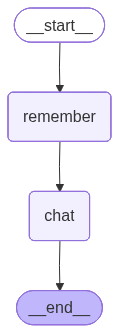

In [13]:
builder = StateGraph(MessagesState)
builder.add_node("remember", remember_node)
builder.add_node("chat", chat_node)

builder.add_edge(START, "remember")
builder.add_edge("remember", "chat")
builder.add_edge("chat", END)

graph = builder.compile(store=store)

graph

In [14]:
config = {"configurable": {"user_id": "u1"}}

In [15]:
result = graph.invoke({"messages": [{"role": "user", "content": "Hi, my name is waseem-akram"}]}, config)
result['messages'][-1].content

'Hi waseem-akram! It\'s great to meet you. Your name carries a wonderful meaning rooted in Arabic and Persian heritage.\n\n**Waseem** means **"handsome," "graceful,"** or **"good-looking,"** derived from the Arabic root و-س-م (w-s-m), which relates to beauty and aesthetic appeal[3][8]. **Akram** translates to **"generous"** or **"noble,"** stemming from concepts of generosity and nobility[9].\n\nTogether, **Waseem Akram** conveys qualities of grace, elegance, and generosity—a combination that reflects both physical charm and noble character[1]. The name is particularly significant in Islamic and South Asian cultures, where it\'s chosen to inspire these admirable qualities in those who bear it[1].\n\nYour name also carries notable cultural resonance due to its association with **Wasim Akram**, the legendary Pakistani cricketer known as the "Sultan of Swing," who was a left-arm fast bowler and a key figure in Pakistan\'s 1992 Cricket World Cup victory[3]. This connection adds a layer of 

In [16]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

The user's name is waseem-akram.


In [17]:
result = graph.invoke({"messages": [{"role": "user", "content": "I teach AI on YouTube"}]}, config)
print(result['messages'][-1].content)

Thanks for sharing that, waseem-akram! Since you teach AI on YouTube, you're part of a thriving ecosystem that's fundamentally transforming how people learn artificial intelligence globally.

The search results highlight just how impactful AI education on YouTube has become. **YouTube has become the world's largest informal university for AI and machine learning**, with at least 2.53 billion people using the platform as of January 2025[2]. What's particularly compelling is that YouTube creators are now **rivaling university courses in depth**, covering everything from deep learning fundamentals to applied computer vision[2]. The platform's recommendation algorithm drives 70% of what people watch, giving educators like you significant reach[2].

The most successful AI channels on YouTube employ diverse teaching approaches tailored to different learning styles[1][2]:

- **Research interpretation**: Channels like Two Minute Papers (1.74M subscribers) simplify complex AI research papers th

In [18]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

The user's name is waseem-akram.
The user teaches AI on YouTube.


In [19]:
result = graph.invoke({"messages": [{"role": "user", "content": "Explain GenAI simply"}]}, config)
print(result['messages'][-1].content)

**Generative AI (GenAI) is a type of artificial intelligence that creates new content—like text, images, videos, audio, or code—by learning patterns from massive datasets and responding to user prompts.** Unlike traditional AI, which analyzes existing data to make predictions, GenAI generates original outputs that mimic what it was trained on.[1][2][3][5]

### How It Works Simply
GenAI relies on advanced models like **large language models (LLMs)** or neural networks, often built on **transformer architecture**:
1. **Training**: The model studies huge amounts of data (e.g., books, websites, images) to spot patterns, structures, and relationships.[1][3][6]
2. **Generation**: Given a prompt (e.g., "Write a poem about cats"), it predicts and builds new content that fits those patterns, making it feel creative but based on learned probabilities.[2][4][7]
3. **Refinement**: Techniques like GANs (Generative Adversarial Networks) pit creator vs. critic models to improve realism.[4]

Examples 

In [20]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

The user's name is waseem-akram.
The user teaches AI on YouTube.
